# Flowers Classification App
In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using this dataset of 102 flower categories.
<img src='1.png' width=500px>

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import torchvision.transforms as T

from model import create_model
from data import create_data_loader

In [17]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f) 

In [2]:
# The directories
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# creating the dataloader
train_data,test_data,valid_data,trainloader , validloader , testloader =create_data_loader(train_dir,valid_dir,test_dir)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model=create_model()

C:\Users\mosta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mosta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training 

In [6]:
epochs = 3
steps = 0
running_loss = 0
print_every = 5

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 9.359.. Test loss: 5.259.. Test accuracy: 0.006
Epoch 1/3.. Train loss: 5.091.. Test loss: 4.234.. Test accuracy: 0.015
Epoch 1/3.. Train loss: 4.480.. Test loss: 4.059.. Test accuracy: 0.078
Epoch 1/3.. Train loss: 4.313.. Test loss: 3.800.. Test accuracy: 0.110
Epoch 1/3.. Train loss: 4.005.. Test loss: 3.458.. Test accuracy: 0.176
Epoch 1/3.. Train loss: 3.706.. Test loss: 3.076.. Test accuracy: 0.230
Epoch 1/3.. Train loss: 3.420.. Test loss: 2.796.. Test accuracy: 0.282
Epoch 1/3.. Train loss: 3.071.. Test loss: 2.474.. Test accuracy: 0.348
Epoch 1/3.. Train loss: 2.748.. Test loss: 2.227.. Test accuracy: 0.359
Epoch 1/3.. Train loss: 2.605.. Test loss: 2.052.. Test accuracy: 0.399
Epoch 1/3.. Train loss: 2.339.. Test loss: 1.930.. Test accuracy: 0.422
Epoch 1/3.. Train loss: 2.479.. Test loss: 1.654.. Test accuracy: 0.485
Epoch 1/3.. Train loss: 2.265.. Test loss: 1.570.. Test accuracy: 0.504
Epoch 1/3.. Train loss: 2.075.. Test loss: 1.582.. Test accuracy

In [8]:
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        ps = torch.exp(logps)
        
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class  == labels.view(*top_class.shape)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor))#.item()
        
    print(f"Accuracy: {accuracy/len(validloader)}")

Accuracy: 0.72142094373703


In [9]:
model.class_to_idx =train_data.class_to_idx

# Saving The Model

In [10]:
checkpoint = {'pretrained_weights': model.state_dict(),
              'classifier':  model.classifier,
              'mapping': model.class_to_idx,
              'state_dict': model.state_dict(),
              'model_architecture': 'vgg16',
              'optimizer' : optimizer.state_dict(),
              'optimizer_algorithm': 'Adam',
              'epochs': epoch,
              'batch_size': 64 ,
              'learning_rate': 0.003 ,
              'classifier_input_size': 25088,
              'classifier_output_size': 102,
              'hidden_layers':1000
              } 
torch.save(checkpoint , 'checkpoint.pth')

# Loading The Model

In [11]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained=True)
    classifier = checkpoint['classifier']
    model.classifier=classifier
    model.class_to_idx = checkpoint ['mapping']
    model.load_state_dict (checkpoint ['state_dict'])
    lr = checkpoint['learning_rate']
    inp_size = checkpoint['classifier_input_size']
    out_size = checkpoint['classifier_output_size']
    batch_size = checkpoint['batch_size']
    for param in model.parameters(): 
        param.requires_grad = False 
    return model

In [12]:
model=load_checkpoint('checkpoint.pth')

# Testing The Model

In [13]:
def process_image( image):
    image=Image.open(image)
    if image.size[0] > image.size[1]:
        aspect = image.size[1] / 256
        new_size = (image.size[0] / aspect, 256)   
    else:
        aspect = image.size[0] / 256
        new_size = (256, image.size[1] / aspect)
    image.thumbnail(new_size, Image.ANTIALIAS)
        
    width, height = image.size # Get dimensions
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))
    np_image = np.array(image)
    np_image = np.transpose(np_image, (2, 0, 1)) # HWC -> CxHxW format.
    np_image = np_image / 255.0
    for h in range(np_image.shape[1]):
        for w in range(np_image.shape[2]):
            np_image[0, h, w] = ((np_image[0, h, w] - 0.485) / 0.229)
            np_image[1, h, w] = ((np_image[1, h, w] - 0.456) / 0.224)
            np_image[2, h, w] = ((np_image[2, h, w] - 0.406) / 0.225)
    
    
        
    return np_image

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

        # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')
    return ax

In [15]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    image=process_image(image_path)
    inputs = torch.tensor(np.array([image])).type(torch.FloatTensor)
    
    inputs = inputs.to(device)
    with torch.no_grad():
        
        logps = model.forward(inputs)
        ps = torch.exp(logps)
        ps=ps.cpu()
        probs, classes = ps.topk(topk, dim=1)
    probs = probs.tolist()[0]
    class_to_idx = train_data.class_to_idx
    idx_to_class = {value:key for key, value in class_to_idx.items()}
    classes=classes.tolist()[0]
    classes = [idx_to_class[i] for i in classes]
    return (probs,classes)
    print(probs)
    print(classes)

C:\Users\mosta\AppData\Local\Temp\ipykernel_3044\286981166.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image.thumbnail(new_size, Image.ANTIALIAS)


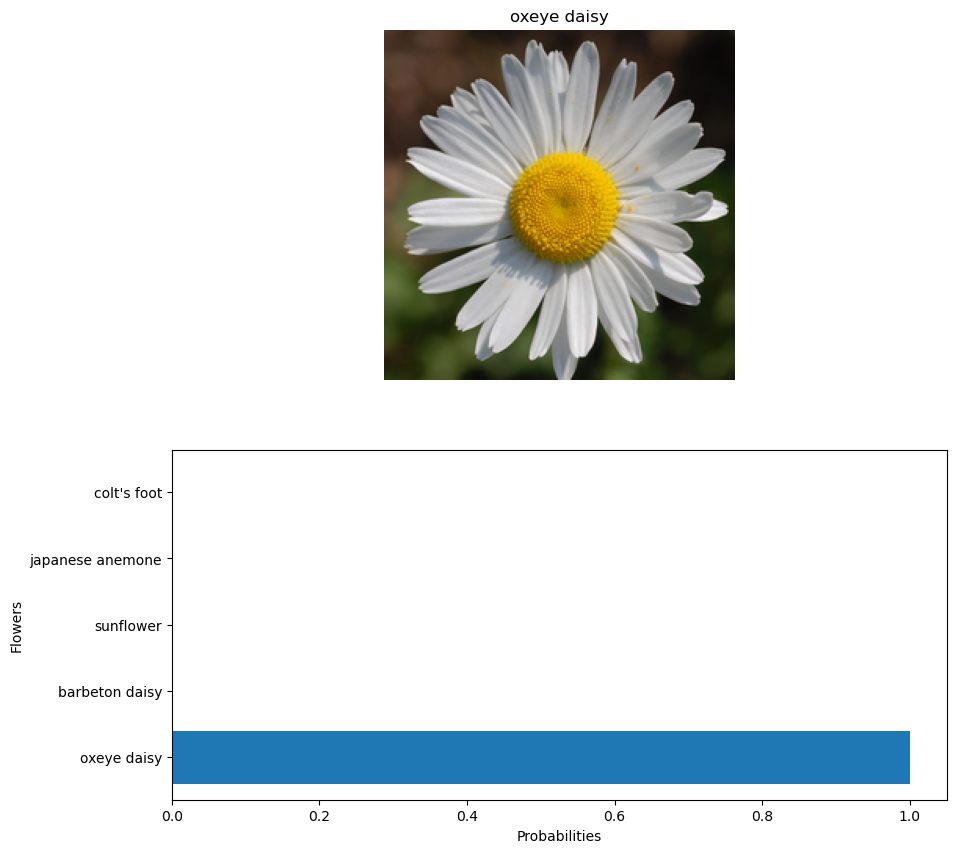

In [18]:
def sanity_checking(image_path, model, device):
    
    fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(10,10))
    image=process_image(image_path)
    probabilities, classes = predict(image_path, model, 5)
    imshow(image, ax=ax1)
    ax1.set_title(cat_to_name[classes[0]])
    ax1.axis('off')
# Display probabilities bar chart

    classes=[cat_to_name[i] for i in classes]

    ax2.barh(classes, probabilities)

    ax2.set_ylabel("Flowers")

    ax2.set_xlabel("Probabilities")

    plt.show()
    
image_path = '3.jpg'

sanity_checking(image_path, model, device)